In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import argparse
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
from tensorflow.python.client import device_lib

def get_gpu():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == "GPU"]

print(get_gpu())

['/device:GPU:0']


In [5]:
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    epochs = range(len(acc))

    # Plot training and validation accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Vẽ đồ thị độ chính xác trong subplot đầu tiên
    ax1.plot(epochs, acc, 'teal', label='Training acc')
    ax1.plot(epochs, val_acc, 'orange', label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot training and validation loss
    ax2.plot(epochs, loss, 'teal', label='Training loss')
    ax2.plot(epochs, val_loss, 'orange', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

### The paths for val_dir and train_dir need to be changed if you use a different dataset or retrain on your machine.

In [6]:
# Define data generators
train_dir = '/kaggle/input/face-expression-recognition-dataset/images/train/'
val_dir = '/kaggle/input/face-expression-recognition-dataset/images/validation/'

num_train = 28821
num_val = 7066
batch_size = 64
num_epoch = 60

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=False)

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [7]:
def count_images_in_classes(path):
    classes = os.listdir(path)
    for c in classes:
        num_images = len(os.listdir(os.path.join(path, c)))
        print(f"Class {c}: {num_images} images")

# Count the number of images in each class for training, testing and validation sets
print("Train images:")
count_images_in_classes(train_dir)

print("\nValidation images:")
count_images_in_classes(val_dir)

Train images:
Class surprise: 3205 images
Class fear: 4103 images
Class angry: 3993 images
Class neutral: 4982 images
Class sad: 4938 images
Class disgust: 436 images
Class happy: 7164 images

Validation images:
Class surprise: 797 images
Class fear: 1018 images
Class angry: 960 images
Class neutral: 1216 images
Class sad: 1139 images
Class disgust: 111 images
Class happy: 1825 images


In [8]:
import tensorflow as tf
with tf.device('/device:GPU:0'):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1))) 
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Dropout(0.45)) 
  
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Dropout(0.45)) 
  
    model.add(Flatten()) 
    model.add(Dense(1024, activation='relu')) 
    model.add(Dropout(0.55)) 
    model.add(Dense(7, activation='softmax')) 

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                   

In [10]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

with tf.device('/device:GPU:0'):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [11]:
with tf.device('/device:GPU:0'):
    model_info = model.fit_generator(
        train_generator,
        steps_per_epoch=num_train // batch_size,
        epochs=num_epoch,
        validation_data=validation_generator,
        validation_steps=num_val // batch_size)

    model_path = "/kaggle/working/model_Project1_betaE.h5"
    model.save_weights(model_path)

/tmp/ipykernel_23/2207085633.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_info = model.fit_generator(


Epoch 1/60


2024-06-18 04:46:01.478125: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1718685964.234023      98 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


450/450 [==============================] - 247s 537ms/step - loss: 1.8702 - accuracy: 0.2169 - val_loss: 1.8560 - val_accuracy: 0.2592
Epoch 2/60
450/450 [==============================] - 28s 63ms/step - loss: 1.8451 - accuracy: 0.2481 - val_loss: 1.8258 - val_accuracy: 0.2605
Epoch 3/60
450/450 [==============================] - 31s 68ms/step - loss: 1.8252 - accuracy: 0.2434 - val_loss: 1.7808 - val_accuracy: 0.2639
Epoch 4/60
450/450 [==============================] - 29s 65ms/step - loss: 1.7813 - accuracy: 0.2732 - val_loss: 1.7350 - val_accuracy: 0.3207
Epoch 5/60
450/450 [==============================] - 29s 65ms/step - loss: 1.7206 - accuracy: 0.3107 - val_loss: 1.7175 - val_accuracy: 0.3294
Epoch 6/60
450/450 [==============================] - 29s 64ms/step - loss: 1.6814 - accuracy: 0.3359 - val_loss: 1.6243 - val_accuracy: 0.3849
Epoch 7/60
450/450 [==============================] - 29s 64ms/step - loss: 1.6378 - accuracy: 0.3603 - val_loss: 1.5651 - val_accuracy: 0.3990
E

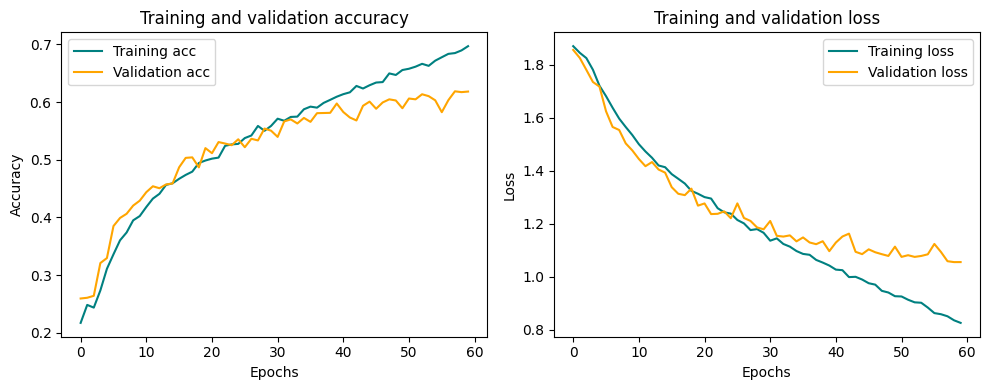

In [12]:
plot_model_history(model_info)

In [13]:
from keras.models import load_model
from keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

1/1 [==============================] - 0s 260ms/step
[[0. 0. 0. 1. 0. 0. 0.]]
Giá trị dự đoán: Hạnh phúc


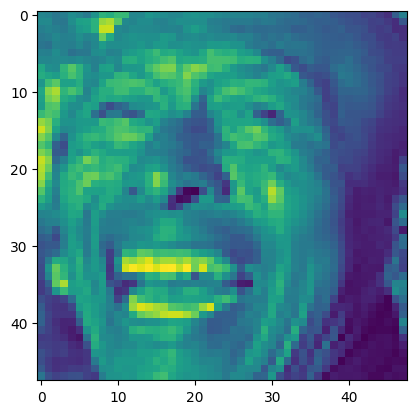

In [14]:
emotion_dict = {0: "Tức giận", 1: "Ghê tởm", 2: "Sợ hãi", 3: "Hạnh phúc", 4: "Vô cảm", 5: "Buồn", 6: "Ngạc nhiên"}

model.load_weights(model_path)

path = '/kaggle/input/face-expression-recognition-dataset/images/validation/happy/10344.jpg'

plt.imshow(mpimg.imread(path))

desired_size = (48, 48)

# Mở ảnh và chuyển đổi sang thang độ xám
img = Image.open(path).convert('L')

# Thay đổi kích thước của ảnh
img = img.resize(desired_size)

# Chuyển ảnh thành mảng và thêm một chiều batch
x = np.array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

y_predict = model.predict(images, batch_size = 10)
print(y_predict)

# Sử dụng Dictionary để lấy cảm xúc tương ứng với nhãn
prediction = int(np.argmax(y_predict))
print("Giá trị dự đoán:", emotion_dict[prediction])

In [15]:
# Tính toán nhãn thực tế và dự đoán
y_test = validation_generator.classes
predictions = model.predict(validation_generator, steps=np.ceil(num_val/batch_size))
y_pred = np.argmax(predictions, axis=1)

# Kiểm tra kích thước của y_test và y_pred
if len(y_test) != len(y_pred):
    print("Kích thước của y_test và y_pred không khớp. Điều chỉnh số bước (steps) hoặc batch_size.")

# Tính toán và vẽ ma trận nhầm lẫn
conf_mat = confusion_matrix(y_test, y_pred)

111/111 [==============================] - 5s 48ms/step


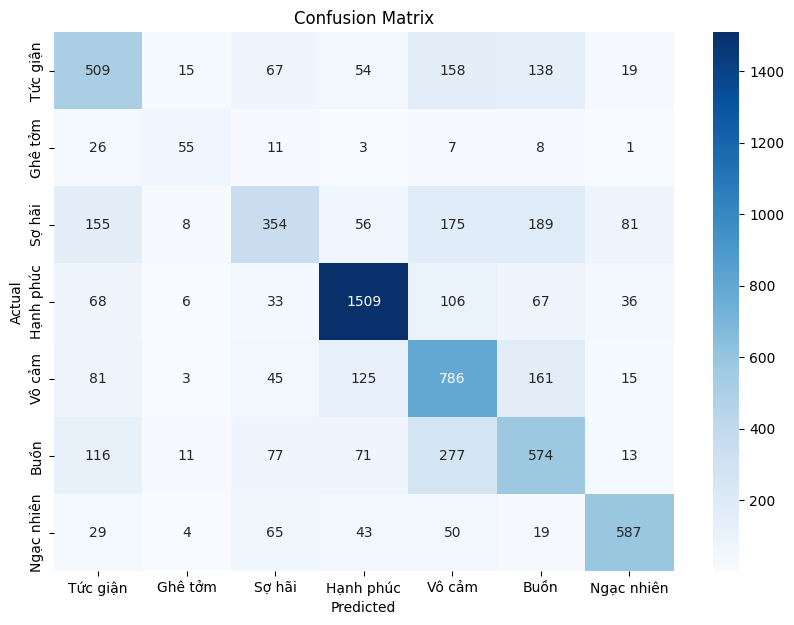

In [16]:
CLASS_LABELS = ['Tức giận', 'Ghê tởm', 'Sợ hãi', 'Hạnh phúc', 'Vô cảm', 'Buồn', 'Ngạc nhiên']

cm = pd.DataFrame(conf_mat, columns=CLASS_LABELS, index=CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# In báo cáo phân loại
print(classification_report(y_test, y_pred, target_names=CLASS_LABELS))

              precision    recall  f1-score   support

    Tức giận       0.52      0.53      0.52       960
     Ghê tởm       0.54      0.50      0.52       111
      Sợ hãi       0.54      0.35      0.42      1018
   Hạnh phúc       0.81      0.83      0.82      1825
      Vô cảm       0.50      0.65      0.57      1216
        Buồn       0.50      0.50      0.50      1139
  Ngạc nhiên       0.78      0.74      0.76       797

    accuracy                           0.62      7066
   macro avg       0.60      0.58      0.59      7066
weighted avg       0.62      0.62      0.62      7066

